In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from model import C2F_TCN
from utility.adaptive_data_loader import Breakfast, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='3'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=12,
    learning_rate=5e-4,
    weight_decay=0,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=1,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=2,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-c2ftcn-speed/",
    project_name="breakfast-split-2",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 12, 'learning_rate': 0.0005, 'weight_decay': 0, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 1, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 2, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-c2ftcn-speed/', 'project_name': 'breakfast-split-2', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split2.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split2.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_split'

In [7]:
traindataset = Breakfast(config, fold='train', fold_file_name=config.train_split_file)
testdataset = Breakfast(config, fold='test', fold_file_name=config.test_split_file)

Number of videos logged in train fold is 1261
Number of videos not found in train fold is 0
Number of videos logged in test fold is 451
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, 
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4,
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)

In [9]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [10]:
loaded_vidid_selected_frames = np.load("/home/dipika16/ar/TimestampActionSeg/data/breakfast_annotation_all.npy", allow_pickle=True).item()
# loaded_vidid_selected_frames
video_id_boundary_frames = pickle.load(open("dump_dir/chunk_1_video_id_boundary_frames_dict.pkl", "rb"))
# video_id_boundary_frames

In [11]:
loaded_mean_var_actions = pickle.load(open("dump_dir/mean_var_actions.pkl", "rb"))
def get_possion_prob(cur_len, cur_class):
    mean_class, std_class = loaded_mean_var_actions[cur_class]
    mean_class = mean_class * 10
    prob = cur_len * torch.log(torch.tensor(mean_class, device=device) + 1e-5)
    prob = prob - mean_class
    factorials = torch.cumsum(torch.log(torch.arange(1, torch.max(cur_len)+1, 1).type(torch.float).to(device)), 
                              dim=0)[min(cur_len)-1:]
    prob = prob - factorials
    return prob

# get_possion_prob(torch.arange(10, 21), 20)

In [12]:
prob_video_each_segment_dict = {}

In [13]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
    cur_boundary = 0
    for i, cur_ele in enumerate(selected_frames[:-1]):

        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[cur_ele]
        label_next_ele = labels[next_ele]

        indices = torch.arange(cur_ele, next_ele).to(cumsum_feat.device)
        strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
        end_index = cumsum_feat[next_ele - 1, :][None, :]
        left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
        right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]

        cur_boundary_len = indices - cur_boundary
        len_prob = get_possion_prob(cur_boundary_len, label_cur_ele.item())

        prob = torch.softmax((left_sum + right_sum + len_prob), dim=0)
#         prob = torch.softmax((left_sum + right_sum), dim=0)

        cur_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob.detach().cpu().numpy()).item())
        prob_each_segment.append(prob)
    
    return prob_each_segment

In [14]:
selected_frames = torch.tensor([2, 10, 17, 21])
cur_vid_feat = torch.randn((27, 48))
labels = torch.tensor([47, 47, 47, 47, 47, 4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10])
# print(len(labels))
# probs_all_segs = prob_vals_per_segment_new(selected_frames, cur_vid_feat, labels)
# print(probs_all_segs)



In [15]:
def calculate_element_probb(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        prob_video = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [16]:
def get_estimated_loss(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames[0]
        if start_ele_idx > 0:
            start_ele_label_idx = labels[selected_frames[0]]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob.unsqueeze(0))
        
        for i, cur_ele in enumerate(selected_frames[:-1]):
            next_ele = selected_frames[i + 1]
            label_cur_ele = labels[cur_ele]
            label_next_ele = labels[next_ele]

            indices = torch.arange(cur_ele, next_ele)
            strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
            end_index = cumsum_feat[next_ele - 1, :][None, :]
            left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
            right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]
            current_vid_prob_arr.append((left_sum + right_sum)  * (prob_each_video[i]))
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = labels[selected_frames[-1]]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames[-1] - 1, :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob.unsqueeze(0))
            
        loss_arr.append(torch.cat(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr

In [17]:
train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])

def get_estimated_boundaries():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames, video_id_boundary_frames
    estimated_boundary_dict = {}
    for ele in video_id_boundary_frames.keys():
        if (ele + ".txt") not in train_split_file_list:
            continue
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        selected_ele_list = loaded_vidid_selected_frames[ele + ".txt"]
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_ele_list[i], selected_ele_list[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = round(estimated_boundary.item())
            
            if (estimated_boundary < selected_ele_list[i]) or (estimated_boundary > selected_ele_list[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [18]:
train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])

def get_boundary_err():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for ele in video_id_boundary_frames.keys():
        if ele + ".txt" not in train_split_file_list:
            continue
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(video_id_boundary_frames[ele][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = video_id_boundary_frames[ele][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"Train From boundary avergage accuracy = {correct * 100.0 / total:.3f}")

In [19]:
def get_ensemble_out(outp):
        
        weights = [1, 1, 1, 1, 1, 1]
        vidlen = outp[0].shape[-1]
        ensemble_prob = F.softmax(outp[0], dim=1) * weights[0] / sum(weights)

        for i, outp_ele in enumerate(outp[1]):
            upped_logit = F.upsample(outp_ele, size=vidlen, mode='nearest')
            ensemble_prob = ensemble_prob + F.softmax(upped_logit, dim=1) * weights[i+1] / sum(weights)
        
        return ensemble_prob


In [20]:
set_seed()
model = C2F_TCN(n_channels=2048, n_classes=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Requires loaded_vidid_selected_frames, boundaries_dict
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [21]:
def get_single_random(labels_all, video_ids):
    # Generate target for only timestamps. Do not generate pseudo labels at first 30 epochs.
    boundary_target_tensor = torch.ones((labels_all.shape[0], labels_all.shape[1]), dtype=torch.long, device=labels_all.device) * (-100)
    for iter_num, labels in enumerate(labels_all):
        cur_vidid = video_ids[iter_num]
        frame_idx_tensor = torch.from_numpy(np.array(loaded_vidid_selected_frames[cur_vidid + ".txt"]))
        boundary_target_tensor[iter_num, frame_idx_tensor] = labels[frame_idx_tensor]

    return boundary_target_tensor

In [23]:
initialize_epoch = 50
expectation_cal_gap = 5
best_val_acc = 0.0
for epoch in range(51, 1000):
    print("Starting Training")
    model.train()
    for i, item in enumerate(trainloader):
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
        optimizer.zero_grad()
        
        y, y_list, x = model(item_0)
        probs = torch.softmax(y, dim=1) # get_ensemble_out([y, y_list])
#         logits = torch.log(probs + 1e-8)
        
        boundary_target_tensor = get_single_random(item_2, item[4])
        
        loss = 0
        if epoch <= initialize_epoch:
            loss += ce_criterion(y, boundary_target_tensor)
            loss += 0.15 * torch.mean(torch.clamp(mse_criterion(F.log_softmax(y[:, :, 1:], dim=1), 
                                                                F.log_softmax(y.detach()[:, :, :-1], dim=1)), min=0,
                                            max=16) * src_mask_mse[:, :, 1:])
        else:
            probs = probs.permute(0, 2, 1)
            es_loss, _ = get_estimated_loss(probs, item_1, item[4], item_2)
            loss += es_loss
            probs = probs.permute(0, 2, 1)
            

        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                pred = torch.argmax(probs, dim=1)
                correct = float(torch.sum((pred == item_2) * src_mask).item())
                total = float(torch.sum(src_mask).item())
                print(f"Training:: Epoch {epoch}, Iteration {i}, Current loss {loss.item()}" +
                      f" Accuracy {correct * 100.0 / total}")
                
    # Calculating Expectation Step
    model.eval()

    if (epoch >= initialize_epoch) and (epoch % expectation_cal_gap == 0):
        print("Calculating Expectation")
        correct = 0.0
        total = 0.0

        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item_0 = item[0].to(device)
                item_1 = item[1].to(device)
                item_2 = item[2].to(device)
                src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
                src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

                y, y_list, x = model(item_0)
                probs = torch.softmax(y, dim=1) # get_ensemble_out([y, y_list])
                
                probs = probs.permute(0, 2, 1)
                calculate_element_probb(probs, item_1, item[4], item_2)
                
                if i % 10 == 0:
                    print(f"Epoch {epoch} iter {i}")
                    
        get_boundary_err()
        
    if epoch == initialize_epoch:
        torch.save(model.state_dict(), config.output_dir + "c2f-tcn-initial-15-epochs.wt")

    if epoch % 1 == 0:
        
        print("Calculating Validation Data Accuracy")
        correct = 0.0
        total = 0.0
        for i, item in enumerate(testloader):
            with torch.no_grad():
                item_0 = item[0].to(device)
                item_1 = item[1].to(device)
                item_2 = item[2].to(device)
                src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
                src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

                y, y_list, x = model(item_0)
                probs = torch.softmax(y, dim=1) # get_ensemble_out([y, y_list])
                
                pred = torch.argmax(probs, dim=1)
                correct += float(torch.sum((pred == item_2) * src_mask).item())
                total += float(torch.sum(src_mask).item())
        val_acc = correct * 100.0 / total
        if val_acc > best_val_acc:
            torch.save(model.state_dict(), config.output_dir + "c2f-tcn-emmax-best-model.wt")
        torch.save(model.state_dict(), config.output_dir + "c2f-tcn-emmax-last-model.wt")
        print(f"Validation:: Epoch {epoch}, Probability Accuracy {correct * 100.0 / total}")

Starting Training
Training:: Epoch 51, Iteration 0, Current loss 1.7082586315795611 Accuracy 55.74887261329837
Training:: Epoch 51, Iteration 10, Current loss 1.4466733176037352 Accuracy 55.95289823585644
Training:: Epoch 51, Iteration 20, Current loss 1.3042550413756027 Accuracy 60.6830122591944
Training:: Epoch 51, Iteration 30, Current loss 1.7367972136614942 Accuracy 52.99371115990027
Training:: Epoch 51, Iteration 40, Current loss 1.4932500063856358 Accuracy 60.20248770610356
Training:: Epoch 51, Iteration 50, Current loss 2.765516308336366 Accuracy 36.45797972940207
Training:: Epoch 51, Iteration 60, Current loss 1.2996258656499822 Accuracy 58.630607747189124
Training:: Epoch 51, Iteration 70, Current loss 1.6169483494873738 Accuracy 46.61617028581237
Training:: Epoch 51, Iteration 80, Current loss 1.1245592758752196 Accuracy 65.85720736541067
Training:: Epoch 51, Iteration 90, Current loss 1.1701000103446915 Accuracy 66.42120765832107
Training:: Epoch 51, Iteration 100, Current 

Calculating Validation Data Accuracy
Validation:: Epoch 57, Probability Accuracy 42.526929610142105
Starting Training
Training:: Epoch 58, Iteration 0, Current loss 0.5035427637736076 Accuracy 76.49915464585057
Training:: Epoch 58, Iteration 10, Current loss 0.5303166561646392 Accuracy 78.00705161551356
Training:: Epoch 58, Iteration 20, Current loss 0.4646450940555518 Accuracy 79.0
Training:: Epoch 58, Iteration 30, Current loss 0.5453710693090695 Accuracy 78.29837569602724
Training:: Epoch 58, Iteration 40, Current loss 0.6154524851507321 Accuracy 74.49436017113963
Training:: Epoch 58, Iteration 50, Current loss 0.5878837850514795 Accuracy 79.97468487948947
Training:: Epoch 58, Iteration 60, Current loss 0.4902387269140978 Accuracy 84.39799823373565
Training:: Epoch 58, Iteration 70, Current loss 0.44969043868282976 Accuracy 78.2397592833208
Training:: Epoch 58, Iteration 80, Current loss 0.5575066151812721 Accuracy 74.24500160244558
Training:: Epoch 58, Iteration 90, Current loss 0.

Training:: Epoch 64, Iteration 100, Current loss 0.3515173999004345 Accuracy 77.4405064722175
Calculating Validation Data Accuracy
Validation:: Epoch 64, Probability Accuracy 44.16352487881675
Starting Training
Training:: Epoch 65, Iteration 0, Current loss 0.31822084247959526 Accuracy 83.6670651524208
Training:: Epoch 65, Iteration 10, Current loss 0.38412456069454926 Accuracy 83.42776203966005
Training:: Epoch 65, Iteration 20, Current loss 0.3955176677198494 Accuracy 82.53643388969265
Training:: Epoch 65, Iteration 30, Current loss 0.2467095790645749 Accuracy 87.55678068097993
Training:: Epoch 65, Iteration 40, Current loss 0.2789398281399923 Accuracy 81.74326255275314
Training:: Epoch 65, Iteration 50, Current loss 0.359071452080386 Accuracy 82.50088141967329
Training:: Epoch 65, Iteration 60, Current loss 0.3702529328900645 Accuracy 79.24905838041431
Training:: Epoch 65, Iteration 70, Current loss 0.3370985396771773 Accuracy 84.99045541314426
Training:: Epoch 65, Iteration 80, Cur

Training:: Epoch 71, Iteration 50, Current loss 0.2352578394013487 Accuracy 86.4583989418656
Training:: Epoch 71, Iteration 60, Current loss 0.2862039717660691 Accuracy 84.54848651158864
Training:: Epoch 71, Iteration 70, Current loss 0.3528328407051055 Accuracy 77.63077132919594
Training:: Epoch 71, Iteration 80, Current loss 0.27971384359843543 Accuracy 84.32117771577023
Training:: Epoch 71, Iteration 90, Current loss 0.3158706241667717 Accuracy 82.55491329479769
Training:: Epoch 71, Iteration 100, Current loss 0.37072460967170967 Accuracy 82.49471458773785
Calculating Validation Data Accuracy
Validation:: Epoch 71, Probability Accuracy 42.26001574346439
Starting Training
Training:: Epoch 72, Iteration 0, Current loss 0.42907035624781054 Accuracy 79.01319563970166
Training:: Epoch 72, Iteration 10, Current loss 0.31085213179199606 Accuracy 78.34084688455965
Training:: Epoch 72, Iteration 20, Current loss 0.1483118019473762 Accuracy 89.67274772399733
Training:: Epoch 72, Iteration 30,

Training:: Epoch 78, Iteration 40, Current loss 0.35476069946016836 Accuracy 84.10124685610317
Training:: Epoch 78, Iteration 50, Current loss 0.1662276416475642 Accuracy 88.06446023219546
Training:: Epoch 78, Iteration 60, Current loss 0.1950916595684444 Accuracy 85.14796863301414
Training:: Epoch 78, Iteration 70, Current loss 0.18394260043443428 Accuracy 89.66733714993038
Training:: Epoch 78, Iteration 80, Current loss 0.30497398058523745 Accuracy 82.02429149797571
Training:: Epoch 78, Iteration 90, Current loss 0.26335113450750824 Accuracy 86.38045540796963
Training:: Epoch 78, Iteration 100, Current loss 0.35672054399512304 Accuracy 81.57624067883775
Calculating Validation Data Accuracy
Validation:: Epoch 78, Probability Accuracy 41.53146621369682
Starting Training
Training:: Epoch 79, Iteration 0, Current loss 0.2916728833883058 Accuracy 82.54025412829878
Training:: Epoch 79, Iteration 10, Current loss 0.46389578495891326 Accuracy 78.12749268811487
Training:: Epoch 79, Iteration 

Training:: Epoch 85, Iteration 20, Current loss 0.17188909917632778 Accuracy 82.7431597528685
Training:: Epoch 85, Iteration 30, Current loss 0.14223232653059725 Accuracy 87.12485383915812
Training:: Epoch 85, Iteration 40, Current loss 0.21762826205064076 Accuracy 86.00719175713989
Training:: Epoch 85, Iteration 50, Current loss 0.13971072751730837 Accuracy 87.91205393036057
Training:: Epoch 85, Iteration 60, Current loss 0.23579425330821055 Accuracy 85.26766221290717
Training:: Epoch 85, Iteration 70, Current loss 0.2251862062359879 Accuracy 85.32970602566185
Training:: Epoch 85, Iteration 80, Current loss 0.25330538276412035 Accuracy 86.66745815030274
Training:: Epoch 85, Iteration 90, Current loss 0.2775747725442822 Accuracy 84.4775260321281
Training:: Epoch 85, Iteration 100, Current loss 0.3415957887856533 Accuracy 72.2694426756001
Calculating Expectation
Epoch 85 iter 0
Epoch 85 iter 10
Epoch 85 iter 20
Epoch 85 iter 30
Epoch 85 iter 40
Epoch 85 iter 50
Epoch 85 iter 60
Epoch 85

Training:: Epoch 93, Iteration 30, Current loss 0.18629063154046413 Accuracy 87.3236834000616
Training:: Epoch 93, Iteration 40, Current loss 0.15898990681927735 Accuracy 85.32543398102499
Training:: Epoch 93, Iteration 50, Current loss 0.1779974341797212 Accuracy 84.81060199592231
Training:: Epoch 93, Iteration 60, Current loss 0.15081384672610731 Accuracy 88.8247477195611
Training:: Epoch 93, Iteration 70, Current loss 0.16015822368926333 Accuracy 85.301736208345
Training:: Epoch 93, Iteration 80, Current loss 0.10074161499852319 Accuracy 84.8199384341505
Training:: Epoch 93, Iteration 90, Current loss 0.2524214939324082 Accuracy 83.32345469940728
Training:: Epoch 93, Iteration 100, Current loss 0.12169355649141353 Accuracy 86.60691744508962
Calculating Validation Data Accuracy
Validation:: Epoch 93, Probability Accuracy 44.097236607697724
Starting Training
Training:: Epoch 94, Iteration 0, Current loss 0.16053017363008049 Accuracy 89.22097487486027
Training:: Epoch 94, Iteration 10,

Training:: Epoch 100, Iteration 10, Current loss 0.13868104125652578 Accuracy 83.74646340948439
Training:: Epoch 100, Iteration 20, Current loss 0.20098186645396687 Accuracy 80.74216250799743
Training:: Epoch 100, Iteration 30, Current loss 0.14379040170470636 Accuracy 86.18456268065518
Training:: Epoch 100, Iteration 40, Current loss 0.14178703673165516 Accuracy 86.8533762643905
Training:: Epoch 100, Iteration 50, Current loss 0.1589761880114555 Accuracy 78.31014690144956
Training:: Epoch 100, Iteration 60, Current loss 0.12464772006390748 Accuracy 84.88366040289418
Training:: Epoch 100, Iteration 70, Current loss 0.1657141242832013 Accuracy 82.61122289291303
Training:: Epoch 100, Iteration 80, Current loss 0.14061426387101894 Accuracy 83.46138495310318
Training:: Epoch 100, Iteration 90, Current loss 0.1459294625350513 Accuracy 83.44549125168237
Training:: Epoch 100, Iteration 100, Current loss 0.10442325737075812 Accuracy 85.17662966927715
Calculating Expectation
Epoch 100 iter 0
Ep

Training:: Epoch 106, Iteration 70, Current loss 0.11137535040407552 Accuracy 82.91149443817508
Training:: Epoch 106, Iteration 80, Current loss 0.3057542204316487 Accuracy 82.78710848842488
Training:: Epoch 106, Iteration 90, Current loss 0.14738033998693587 Accuracy 84.47976985210047
Training:: Epoch 106, Iteration 100, Current loss 0.14383702363087933 Accuracy 90.45207417889327
Calculating Validation Data Accuracy
Validation:: Epoch 106, Probability Accuracy 44.58228031652649
Starting Training
Training:: Epoch 107, Iteration 0, Current loss 0.18288348014573771 Accuracy 84.01218729955099
Training:: Epoch 107, Iteration 10, Current loss 0.1325534844595868 Accuracy 87.22081218274111
Training:: Epoch 107, Iteration 20, Current loss 0.1335472340006699 Accuracy 86.19276261857361
Training:: Epoch 107, Iteration 30, Current loss 0.17734821346316954 Accuracy 86.17750848924696
Training:: Epoch 107, Iteration 40, Current loss 0.14350427030070875 Accuracy 86.81797259497928
Training:: Epoch 107,

Training:: Epoch 113, Iteration 40, Current loss 0.1355728918739168 Accuracy 86.48108769894968
Training:: Epoch 113, Iteration 50, Current loss 0.08193145563216257 Accuracy 83.77181404898079
Training:: Epoch 113, Iteration 60, Current loss 0.0842819362953601 Accuracy 84.71407624633432
Training:: Epoch 113, Iteration 70, Current loss 1.1021882424802296 Accuracy 68.00802046601673
Training:: Epoch 113, Iteration 80, Current loss 0.10044993180461444 Accuracy 86.34755574614066
Training:: Epoch 113, Iteration 90, Current loss 0.15150521593325383 Accuracy 81.83147927171946
Training:: Epoch 113, Iteration 100, Current loss 0.14837051369954485 Accuracy 85.07163648735494
Calculating Validation Data Accuracy
Validation:: Epoch 113, Probability Accuracy 41.97652980900692
Starting Training
Training:: Epoch 114, Iteration 0, Current loss 0.10729399784596377 Accuracy 85.17342187894756
Training:: Epoch 114, Iteration 10, Current loss 0.12101861628709243 Accuracy 79.4068252048905
Training:: Epoch 114, 

Training:: Epoch 120, Iteration 10, Current loss 0.08665040843572333 Accuracy 82.30504637087996
Training:: Epoch 120, Iteration 20, Current loss 0.23414697036681714 Accuracy 86.56901688182721
Training:: Epoch 120, Iteration 30, Current loss 0.14385286235063882 Accuracy 87.46962332928311
Training:: Epoch 120, Iteration 40, Current loss 0.10340694325496842 Accuracy 90.08539118393723
Training:: Epoch 120, Iteration 50, Current loss 0.11994033824300447 Accuracy 86.90819012230996
Training:: Epoch 120, Iteration 60, Current loss 0.09756912468243109 Accuracy 87.39343293660842
Training:: Epoch 120, Iteration 70, Current loss 0.08912445630961058 Accuracy 90.72948328267478
Training:: Epoch 120, Iteration 80, Current loss 0.07023815943687813 Accuracy 90.15340706386014
Training:: Epoch 120, Iteration 90, Current loss 0.08812277974763506 Accuracy 85.6421449052082
Training:: Epoch 120, Iteration 100, Current loss 0.09219167412772306 Accuracy 88.26363792806745
Calculating Expectation
Epoch 120 iter 0

Training:: Epoch 126, Iteration 70, Current loss 0.14330571830890773 Accuracy 85.75942423311537
Training:: Epoch 126, Iteration 80, Current loss 0.1564208902048089 Accuracy 84.47814451382693
Training:: Epoch 126, Iteration 90, Current loss 0.1567167477986581 Accuracy 84.25531914893617
Training:: Epoch 126, Iteration 100, Current loss 0.12847045701502835 Accuracy 83.80647894919302
Calculating Validation Data Accuracy
Validation:: Epoch 126, Probability Accuracy 45.048576873679416
Starting Training
Training:: Epoch 127, Iteration 0, Current loss 0.08596400241523608 Accuracy 87.80463393884803
Training:: Epoch 127, Iteration 10, Current loss 0.11593475306666935 Accuracy 78.37917526641675
Training:: Epoch 127, Iteration 20, Current loss 0.09160203552145574 Accuracy 80.6988806988807
Training:: Epoch 127, Iteration 30, Current loss 0.07422411360200393 Accuracy 86.30741458848699
Training:: Epoch 127, Iteration 40, Current loss 0.08656826480164377 Accuracy 87.26201550387597
Training:: Epoch 127

Training:: Epoch 133, Iteration 40, Current loss 0.10947229692991368 Accuracy 85.79464324347713
Training:: Epoch 133, Iteration 50, Current loss 0.1663135059900342 Accuracy 82.39332691690728
Training:: Epoch 133, Iteration 60, Current loss 0.10086088349952364 Accuracy 76.55153641422696
Training:: Epoch 133, Iteration 70, Current loss 0.18303148093841604 Accuracy 82.179437812861
Training:: Epoch 133, Iteration 80, Current loss 0.1826289676665437 Accuracy 85.83901773533424
Training:: Epoch 133, Iteration 90, Current loss 0.08956327931334551 Accuracy 86.40412329863891
Training:: Epoch 133, Iteration 100, Current loss 0.10610024789111559 Accuracy 83.29879499577865
Calculating Validation Data Accuracy
Validation:: Epoch 133, Probability Accuracy 45.8993454033227
Starting Training
Training:: Epoch 134, Iteration 0, Current loss 0.0741303702111602 Accuracy 82.56106968372332
Training:: Epoch 134, Iteration 10, Current loss 0.11320660775363023 Accuracy 85.02561156589593
Training:: Epoch 134, It

Training:: Epoch 140, Iteration 10, Current loss 0.2532619082948945 Accuracy 87.12330220713073
Training:: Epoch 140, Iteration 20, Current loss 0.11763288997518043 Accuracy 82.9358647835147
Training:: Epoch 140, Iteration 30, Current loss 0.19468247189519522 Accuracy 84.45281573234581
Training:: Epoch 140, Iteration 40, Current loss 0.12239220014082605 Accuracy 79.05794001616046
Training:: Epoch 140, Iteration 50, Current loss 0.1994399647276901 Accuracy 85.22640234287002
Training:: Epoch 140, Iteration 60, Current loss 0.13820768225704583 Accuracy 87.85581807918716
Training:: Epoch 140, Iteration 70, Current loss 0.15550252424281386 Accuracy 77.83516247041102
Training:: Epoch 140, Iteration 80, Current loss 0.0956779574668318 Accuracy 83.31520425429055
Training:: Epoch 140, Iteration 90, Current loss 0.11450576084195671 Accuracy 87.3997559274756
Training:: Epoch 140, Iteration 100, Current loss 0.1343067923476882 Accuracy 88.16203335980937
Calculating Expectation
Epoch 140 iter 0
Epoc

Training:: Epoch 146, Iteration 70, Current loss 0.0838180250515103 Accuracy 88.02617480483698
Training:: Epoch 146, Iteration 80, Current loss 0.064648118653783 Accuracy 87.55331723110129
Training:: Epoch 146, Iteration 90, Current loss 0.07967288841648004 Accuracy 86.95974530071089
Training:: Epoch 146, Iteration 100, Current loss 0.09493119628213909 Accuracy 82.40711437432749
Calculating Validation Data Accuracy
Validation:: Epoch 146, Probability Accuracy 45.49643700542735
Starting Training
Training:: Epoch 147, Iteration 0, Current loss 0.08530038688594412 Accuracy 82.54917199736953
Training:: Epoch 147, Iteration 10, Current loss 0.11650131515700926 Accuracy 87.80918139751657
Training:: Epoch 147, Iteration 20, Current loss 0.30742419331927906 Accuracy 74.54555204032388
Training:: Epoch 147, Iteration 30, Current loss 0.09017850534455131 Accuracy 82.71389584447007
Training:: Epoch 147, Iteration 40, Current loss 0.1286279611295533 Accuracy 81.90194142810135
Training:: Epoch 147, 

Training:: Epoch 153, Iteration 40, Current loss 0.09857155878413808 Accuracy 90.02090144166354
Training:: Epoch 153, Iteration 50, Current loss 0.0959544862908192 Accuracy 86.44164555607094
Training:: Epoch 153, Iteration 60, Current loss 0.23528277580474513 Accuracy 76.10538791138663
Training:: Epoch 153, Iteration 70, Current loss 0.06675234289069602 Accuracy 86.14659975987439
Training:: Epoch 153, Iteration 80, Current loss 0.06131741949940776 Accuracy 89.99740417063252
Training:: Epoch 153, Iteration 90, Current loss 0.11869174842898693 Accuracy 79.14674512688488
Training:: Epoch 153, Iteration 100, Current loss 0.10748289495188797 Accuracy 85.1664637088436
Calculating Validation Data Accuracy
Validation:: Epoch 153, Probability Accuracy 46.638770352570745
Starting Training
Training:: Epoch 154, Iteration 0, Current loss 0.07878919862424878 Accuracy 89.81340270924913
Training:: Epoch 154, Iteration 10, Current loss 0.08990949960981688 Accuracy 81.65174328447802
Training:: Epoch 15

Training:: Epoch 160, Iteration 10, Current loss 0.06867750671242351 Accuracy 78.96304318397185
Training:: Epoch 160, Iteration 20, Current loss 0.12414963456059763 Accuracy 88.89130041598843
Training:: Epoch 160, Iteration 30, Current loss 0.12515749958720376 Accuracy 89.14796730125637
Training:: Epoch 160, Iteration 40, Current loss 0.04969360377256735 Accuracy 89.09064241713112
Training:: Epoch 160, Iteration 50, Current loss 0.09550744719632885 Accuracy 87.31313400961025
Training:: Epoch 160, Iteration 60, Current loss 0.13591766037312342 Accuracy 84.91668906208008
Training:: Epoch 160, Iteration 70, Current loss 0.04872499125170011 Accuracy 85.27551942186089
Training:: Epoch 160, Iteration 80, Current loss 0.22123802733591105 Accuracy 80.02633528104683
Training:: Epoch 160, Iteration 90, Current loss 0.09200443192552046 Accuracy 87.71632337539275
Training:: Epoch 160, Iteration 100, Current loss 0.09494354804238914 Accuracy 83.91805034815212
Calculating Expectation
Epoch 160 iter 

Training:: Epoch 166, Iteration 70, Current loss 0.07610146660465567 Accuracy 84.45686634406808
Training:: Epoch 166, Iteration 80, Current loss 0.09026828061734973 Accuracy 87.71572455157585
Training:: Epoch 166, Iteration 90, Current loss 0.0691895140739194 Accuracy 88.37701963512188
Training:: Epoch 166, Iteration 100, Current loss 0.07088144456380809 Accuracy 90.36125997609592
Calculating Validation Data Accuracy
Validation:: Epoch 166, Probability Accuracy 45.280067945477896
Starting Training
Training:: Epoch 167, Iteration 0, Current loss 0.0730358373584035 Accuracy 81.41597952800683
Training:: Epoch 167, Iteration 10, Current loss 0.10939642821095706 Accuracy 89.64149280047017
Training:: Epoch 167, Iteration 20, Current loss 0.07596162772042359 Accuracy 88.59040345342852
Training:: Epoch 167, Iteration 30, Current loss 0.07157456876087225 Accuracy 81.85028029857219
Training:: Epoch 167, Iteration 40, Current loss 0.05889778632040354 Accuracy 85.73121137404335
Training:: Epoch 16

Training:: Epoch 173, Iteration 40, Current loss 0.09549806142203462 Accuracy 90.330225944067
Training:: Epoch 173, Iteration 50, Current loss 0.1300852289407681 Accuracy 88.4769316286826
Training:: Epoch 173, Iteration 60, Current loss 0.15477081926820122 Accuracy 81.0859831094485
Training:: Epoch 173, Iteration 70, Current loss 0.1085618959954366 Accuracy 84.21377437669712
Training:: Epoch 173, Iteration 80, Current loss 0.21921078596220825 Accuracy 82.20088290174304
Training:: Epoch 173, Iteration 90, Current loss 0.16903031627686593 Accuracy 81.54943008946006
Training:: Epoch 173, Iteration 100, Current loss 0.13311123994641047 Accuracy 83.1827027027027
Calculating Validation Data Accuracy
Validation:: Epoch 173, Probability Accuracy 45.638749637486015
Starting Training
Training:: Epoch 174, Iteration 0, Current loss 0.06058527055933349 Accuracy 84.65075715531594
Training:: Epoch 174, Iteration 10, Current loss 0.10821484332346645 Accuracy 84.07884761182714
Training:: Epoch 174, It

Training:: Epoch 180, Iteration 10, Current loss 0.30654642947534827 Accuracy 81.93979933110369
Training:: Epoch 180, Iteration 20, Current loss 0.196518209193121 Accuracy 83.98761649431891
Training:: Epoch 180, Iteration 30, Current loss 0.13770133651487118 Accuracy 85.99686643164904
Training:: Epoch 180, Iteration 40, Current loss 0.0833273539415442 Accuracy 87.63903627716857
Training:: Epoch 180, Iteration 50, Current loss 0.39875006499302973 Accuracy 77.39754524651549
Training:: Epoch 180, Iteration 60, Current loss 0.08048904056349059 Accuracy 86.29622882127892
Training:: Epoch 180, Iteration 70, Current loss 0.09912621530880451 Accuracy 89.27552447552448
Training:: Epoch 180, Iteration 80, Current loss 0.12010648510013228 Accuracy 86.75416904444867
Training:: Epoch 180, Iteration 90, Current loss 0.0812689139129516 Accuracy 85.74324324324324
Training:: Epoch 180, Iteration 100, Current loss 0.1394855186867165 Accuracy 80.44428548720394
Calculating Expectation
Epoch 180 iter 0
Epo

Training:: Epoch 186, Iteration 70, Current loss 0.07350484381434395 Accuracy 86.93467336683418
Training:: Epoch 186, Iteration 80, Current loss 0.06751493053190813 Accuracy 89.28311763850516
Training:: Epoch 186, Iteration 90, Current loss 0.2836777554179629 Accuracy 80.95892626131953
Training:: Epoch 186, Iteration 100, Current loss 0.0555690295401295 Accuracy 88.30267956239099
Calculating Validation Data Accuracy
Validation:: Epoch 186, Probability Accuracy 44.93992625429838
Starting Training
Training:: Epoch 187, Iteration 0, Current loss 0.22664328710727263 Accuracy 84.35644947272854
Training:: Epoch 187, Iteration 10, Current loss 0.12633095800980418 Accuracy 84.6617915904936
Training:: Epoch 187, Iteration 20, Current loss 0.07406122843052296 Accuracy 87.50049133288786
Training:: Epoch 187, Iteration 30, Current loss 0.13865418115849076 Accuracy 83.89731026386976
Training:: Epoch 187, Iteration 40, Current loss 0.07477801589098422 Accuracy 86.55918889294848
Training:: Epoch 187,

Training:: Epoch 193, Iteration 40, Current loss 0.08542446541989346 Accuracy 87.82803306501101
Training:: Epoch 193, Iteration 50, Current loss 0.07910002662059003 Accuracy 81.70340175318351
Training:: Epoch 193, Iteration 60, Current loss 0.07813169512260065 Accuracy 83.30419292052915
Training:: Epoch 193, Iteration 70, Current loss 0.07157557810229119 Accuracy 82.73813474941919
Training:: Epoch 193, Iteration 80, Current loss 0.07848058794605763 Accuracy 89.61829102887037
Training:: Epoch 193, Iteration 90, Current loss 0.13592164897214237 Accuracy 86.69490089784856
Training:: Epoch 193, Iteration 100, Current loss 0.09246409869792499 Accuracy 81.57427580085532
Calculating Validation Data Accuracy
Validation:: Epoch 193, Probability Accuracy 46.75663918465427
Starting Training
Training:: Epoch 194, Iteration 0, Current loss 0.09878059139723626 Accuracy 83.28334648776638
Training:: Epoch 194, Iteration 10, Current loss 0.08455163589710352 Accuracy 82.29239054899236
Training:: Epoch 1

Training:: Epoch 200, Iteration 10, Current loss 0.07021467750892457 Accuracy 84.67328985951245
Training:: Epoch 200, Iteration 20, Current loss 0.05111508268922559 Accuracy 84.48196513835356
Training:: Epoch 200, Iteration 30, Current loss 0.05161236442488505 Accuracy 87.01298701298701
Training:: Epoch 200, Iteration 40, Current loss 0.07807971626906787 Accuracy 79.68863142650254
Training:: Epoch 200, Iteration 50, Current loss 0.05754822136855549 Accuracy 90.60293157676102
Training:: Epoch 200, Iteration 60, Current loss 0.1014319360280186 Accuracy 83.82229673093043
Training:: Epoch 200, Iteration 70, Current loss 0.09600482361827854 Accuracy 84.48791089377886
Training:: Epoch 200, Iteration 80, Current loss 0.04723137761156785 Accuracy 89.06425102726934
Training:: Epoch 200, Iteration 90, Current loss 0.06179567691043495 Accuracy 87.07005423074065
Training:: Epoch 200, Iteration 100, Current loss 0.06924049805771848 Accuracy 85.249438978077
Calculating Expectation
Epoch 200 iter 0
E

Training:: Epoch 206, Iteration 70, Current loss 0.0567016026297864 Accuracy 88.55637924307452
Training:: Epoch 206, Iteration 80, Current loss 0.059000684906880804 Accuracy 85.63111318118304
Training:: Epoch 206, Iteration 90, Current loss 0.08534256432791058 Accuracy 84.66237733151361
Training:: Epoch 206, Iteration 100, Current loss 0.12125908856702466 Accuracy 86.01843367649437
Calculating Validation Data Accuracy
Validation:: Epoch 206, Probability Accuracy 45.91115300161578
Starting Training
Training:: Epoch 207, Iteration 0, Current loss 0.05514160548478176 Accuracy 85.26613320593972
Training:: Epoch 207, Iteration 10, Current loss 0.07878990247678566 Accuracy 90.74649515825986
Training:: Epoch 207, Iteration 20, Current loss 0.07644940778638602 Accuracy 89.11937570998172
Training:: Epoch 207, Iteration 30, Current loss 0.09161139163597297 Accuracy 84.43303816315336
Training:: Epoch 207, Iteration 40, Current loss 0.06770887541740797 Accuracy 88.08111727568395
Training:: Epoch 2

Training:: Epoch 213, Iteration 40, Current loss 0.05672260405518891 Accuracy 86.63678324161192
Training:: Epoch 213, Iteration 50, Current loss 0.051838945224281306 Accuracy 87.39989128465302
Training:: Epoch 213, Iteration 60, Current loss 0.05359360946090129 Accuracy 88.26666666666667
Training:: Epoch 213, Iteration 70, Current loss 0.04173342976911887 Accuracy 86.65831712863782
Training:: Epoch 213, Iteration 80, Current loss 0.048036726200600816 Accuracy 84.73297120607604
Training:: Epoch 213, Iteration 90, Current loss 0.03935149758599345 Accuracy 88.64008974027095
Training:: Epoch 213, Iteration 100, Current loss 0.15092498208499228 Accuracy 88.20933446262202
Calculating Validation Data Accuracy
Validation:: Epoch 213, Probability Accuracy 45.16779218627004
Starting Training
Training:: Epoch 214, Iteration 0, Current loss 0.05594671597126979 Accuracy 90.05227998838222
Training:: Epoch 214, Iteration 10, Current loss 0.15845096599773417 Accuracy 85.77527423658464
Training:: Epoch

Training:: Epoch 220, Iteration 10, Current loss 0.040461090866253505 Accuracy 82.59244154431757
Training:: Epoch 220, Iteration 20, Current loss 0.05170503175364286 Accuracy 83.87852291357639
Training:: Epoch 220, Iteration 30, Current loss 0.08002936985715428 Accuracy 82.55771787743261
Training:: Epoch 220, Iteration 40, Current loss 0.04315155378204613 Accuracy 78.48898216159496
Training:: Epoch 220, Iteration 50, Current loss 0.05592337498263071 Accuracy 78.80756835429878
Training:: Epoch 220, Iteration 60, Current loss 0.04429067640622827 Accuracy 88.75263527758257
Training:: Epoch 220, Iteration 70, Current loss 0.06616254241759947 Accuracy 84.2810575878305
Training:: Epoch 220, Iteration 80, Current loss 0.05395666249053557 Accuracy 87.66756032171581
Training:: Epoch 220, Iteration 90, Current loss 0.056997231270243566 Accuracy 88.3855331841909
Training:: Epoch 220, Iteration 100, Current loss 0.05583502784637097 Accuracy 83.78780702347926
Calculating Expectation
Epoch 220 iter 

Training:: Epoch 226, Iteration 70, Current loss 0.049176818822220664 Accuracy 87.89686693182611
Training:: Epoch 226, Iteration 80, Current loss 0.04896457115971445 Accuracy 87.04912266989722
Training:: Epoch 226, Iteration 90, Current loss 0.03722436018335911 Accuracy 86.8151029441352
Training:: Epoch 226, Iteration 100, Current loss 0.14202880442926255 Accuracy 74.49086410354016
Calculating Validation Data Accuracy
Validation:: Epoch 226, Probability Accuracy 44.80455317562249
Starting Training
Training:: Epoch 227, Iteration 0, Current loss 0.09060237397549827 Accuracy 78.2445671894529
Training:: Epoch 227, Iteration 10, Current loss 0.07065448989031532 Accuracy 81.29953563073914
Training:: Epoch 227, Iteration 20, Current loss 0.05236001907747759 Accuracy 83.86312640239342
Training:: Epoch 227, Iteration 30, Current loss 0.06356378578003033 Accuracy 87.78313668073379
Training:: Epoch 227, Iteration 40, Current loss 0.07370596479507548 Accuracy 87.22145886851067
Training:: Epoch 22

Training:: Epoch 233, Iteration 40, Current loss 0.11446569114565301 Accuracy 85.171650797908
Training:: Epoch 233, Iteration 50, Current loss 0.08161538339578861 Accuracy 82.6566401975364
Training:: Epoch 233, Iteration 60, Current loss 0.09263158931919054 Accuracy 83.6385282612393
Training:: Epoch 233, Iteration 70, Current loss 0.05923236164421536 Accuracy 86.29956591718285
Training:: Epoch 233, Iteration 80, Current loss 0.1030015922677081 Accuracy 85.29250031724547
Training:: Epoch 233, Iteration 90, Current loss 0.07664903562494929 Accuracy 89.1297195031669
Training:: Epoch 233, Iteration 100, Current loss 0.11017264410936874 Accuracy 86.70891423743134
Calculating Validation Data Accuracy
Validation:: Epoch 233, Probability Accuracy 44.64732568256204
Starting Training
Training:: Epoch 234, Iteration 0, Current loss 0.10692163790930748 Accuracy 79.85535705733034
Training:: Epoch 234, Iteration 10, Current loss 0.08513014529911947 Accuracy 82.29915631104276
Training:: Epoch 234, It

Training:: Epoch 240, Iteration 10, Current loss 0.06119979935244337 Accuracy 85.5579537278958
Training:: Epoch 240, Iteration 20, Current loss 0.07628616480602633 Accuracy 86.50842454802607
Training:: Epoch 240, Iteration 30, Current loss 0.09975321773282037 Accuracy 88.49496221662469
Training:: Epoch 240, Iteration 40, Current loss 0.17901355247971945 Accuracy 80.82125603864735
Training:: Epoch 240, Iteration 50, Current loss 0.3529569093455253 Accuracy 74.21396830720215
Training:: Epoch 240, Iteration 60, Current loss 0.06829818525769193 Accuracy 88.10906033550867
Training:: Epoch 240, Iteration 70, Current loss 0.056268705605415546 Accuracy 85.68153700604032
Training:: Epoch 240, Iteration 80, Current loss 0.0690890280921879 Accuracy 87.63602376660658
Training:: Epoch 240, Iteration 90, Current loss 0.07326764424946695 Accuracy 87.95539920100173
Training:: Epoch 240, Iteration 100, Current loss 0.06150990278933674 Accuracy 85.23345564975325
Calculating Expectation
Epoch 240 iter 0


Training:: Epoch 246, Iteration 70, Current loss 0.061092738767387876 Accuracy 85.39551209727968
Training:: Epoch 246, Iteration 80, Current loss 0.08669690024567005 Accuracy 83.19260554584062
Training:: Epoch 246, Iteration 90, Current loss 0.041330643256506046 Accuracy 91.08642972536349
Training:: Epoch 246, Iteration 100, Current loss 0.046240593837740526 Accuracy 81.53427056477112
Calculating Validation Data Accuracy
Validation:: Epoch 246, Probability Accuracy 44.39408377180263
Starting Training
Training:: Epoch 247, Iteration 0, Current loss 0.06417037326943453 Accuracy 83.50298974943053
Training:: Epoch 247, Iteration 10, Current loss 0.05255600905856118 Accuracy 88.98587933247754
Training:: Epoch 247, Iteration 20, Current loss 0.06993236285045458 Accuracy 78.64364811885274
Training:: Epoch 247, Iteration 30, Current loss 0.04640503866958918 Accuracy 88.10238030308933
Training:: Epoch 247, Iteration 40, Current loss 0.057108723184833184 Accuracy 86.86463765859733
Training:: Epo

Training:: Epoch 253, Iteration 40, Current loss 0.04388376584418589 Accuracy 87.44786582660396
Training:: Epoch 253, Iteration 50, Current loss 0.08673056736375588 Accuracy 86.83697849659988
Training:: Epoch 253, Iteration 60, Current loss 0.04981425660930528 Accuracy 90.55975794251134
Training:: Epoch 253, Iteration 70, Current loss 0.0808410820272538 Accuracy 87.07095209217708
Training:: Epoch 253, Iteration 80, Current loss 0.04882903424077304 Accuracy 83.48073542951204
Training:: Epoch 253, Iteration 90, Current loss 0.07471194258974077 Accuracy 82.34195342659085
Training:: Epoch 253, Iteration 100, Current loss 0.09341522342845048 Accuracy 86.64091899386017
Calculating Validation Data Accuracy
Validation:: Epoch 253, Probability Accuracy 44.20785516012761
Starting Training
Training:: Epoch 254, Iteration 0, Current loss 0.05840093662250524 Accuracy 75.58362335275486
Training:: Epoch 254, Iteration 10, Current loss 0.05775036187433599 Accuracy 87.13406206809901
Training:: Epoch 25

Training:: Epoch 260, Iteration 10, Current loss 0.07201300484899767 Accuracy 83.20213946916944
Training:: Epoch 260, Iteration 20, Current loss 0.054130239129574695 Accuracy 84.52232851443524
Training:: Epoch 260, Iteration 30, Current loss 0.0743069376453191 Accuracy 84.35762937446175
Training:: Epoch 260, Iteration 40, Current loss 0.051564636870231585 Accuracy 83.31079253448742
Training:: Epoch 260, Iteration 50, Current loss 0.06545628090467355 Accuracy 79.93339676498573
Training:: Epoch 260, Iteration 60, Current loss 0.04951904553327332 Accuracy 82.89951096387443
Training:: Epoch 260, Iteration 70, Current loss 0.10409963278063282 Accuracy 83.26835607537362
Training:: Epoch 260, Iteration 80, Current loss 0.050044488241883296 Accuracy 88.55606372820023
Training:: Epoch 260, Iteration 90, Current loss 0.061264716013141464 Accuracy 81.82410423452768
Training:: Epoch 260, Iteration 100, Current loss 0.04140085475581504 Accuracy 89.45741281089343
Calculating Expectation
Epoch 260 it

Training:: Epoch 266, Iteration 70, Current loss 0.05646043924885337 Accuracy 88.90158063719437
Training:: Epoch 266, Iteration 80, Current loss 0.07424570538016188 Accuracy 82.99510408491236
Training:: Epoch 266, Iteration 90, Current loss 0.06718355299648922 Accuracy 81.13328764776426
Training:: Epoch 266, Iteration 100, Current loss 0.05921026721409684 Accuracy 85.07694052705206
Calculating Validation Data Accuracy
Validation:: Epoch 266, Probability Accuracy 42.80575465053652
Starting Training
Training:: Epoch 267, Iteration 0, Current loss 0.17769032801768475 Accuracy 77.17431877566256
Training:: Epoch 267, Iteration 10, Current loss 0.1670176173600744 Accuracy 84.58362328926003
Training:: Epoch 267, Iteration 20, Current loss 0.07913232933313274 Accuracy 85.45849802371542
Training:: Epoch 267, Iteration 30, Current loss 0.1253031533549924 Accuracy 83.93832762292804
Training:: Epoch 267, Iteration 40, Current loss 0.12253040362556564 Accuracy 81.23992795525642
Training:: Epoch 267

Training:: Epoch 273, Iteration 40, Current loss 0.056058229629344786 Accuracy 87.88973638431688
Training:: Epoch 273, Iteration 50, Current loss 0.06678937409500768 Accuracy 80.74817051327977
Training:: Epoch 273, Iteration 60, Current loss 0.064020821571125 Accuracy 78.41110179752259
Training:: Epoch 273, Iteration 70, Current loss 0.050466009035266705 Accuracy 85.60696065413376
Training:: Epoch 273, Iteration 80, Current loss 0.04973831776496858 Accuracy 89.4576042534619
Training:: Epoch 273, Iteration 90, Current loss 0.04331538112081657 Accuracy 87.87789556340793
Training:: Epoch 273, Iteration 100, Current loss 0.06882494352518681 Accuracy 87.05494693598082
Calculating Validation Data Accuracy
Validation:: Epoch 273, Probability Accuracy 44.52168869370676
Starting Training
Training:: Epoch 274, Iteration 0, Current loss 0.06258079952557676 Accuracy 80.29761053083416
Training:: Epoch 274, Iteration 10, Current loss 0.134152669812698 Accuracy 87.10679611650485
Training:: Epoch 274,

Training:: Epoch 280, Iteration 10, Current loss 0.05929352853995367 Accuracy 82.54166466548196
Training:: Epoch 280, Iteration 20, Current loss 0.0596652652444878 Accuracy 83.88929618768329
Training:: Epoch 280, Iteration 30, Current loss 0.04223739722477591 Accuracy 82.57693917145357
Training:: Epoch 280, Iteration 40, Current loss 0.505251823963212 Accuracy 81.56685646966424
Training:: Epoch 280, Iteration 50, Current loss 0.09629218483183974 Accuracy 86.39383470635131
Training:: Epoch 280, Iteration 60, Current loss 0.07393011468247573 Accuracy 82.71249165807195
Training:: Epoch 280, Iteration 70, Current loss 0.04698031850836273 Accuracy 88.8698129748685
Training:: Epoch 280, Iteration 80, Current loss 0.05600960300013536 Accuracy 82.80305320435308
Training:: Epoch 280, Iteration 90, Current loss 0.060781275250061426 Accuracy 81.60207243358562
Training:: Epoch 280, Iteration 100, Current loss 0.061188779985498466 Accuracy 85.86670871439084
Calculating Expectation
Epoch 280 iter 0


Training:: Epoch 286, Iteration 70, Current loss 0.08631524141080457 Accuracy 87.15050565139798
Training:: Epoch 286, Iteration 80, Current loss 0.07028844910508955 Accuracy 87.20305358846869
Training:: Epoch 286, Iteration 90, Current loss 0.04767110232978127 Accuracy 81.96459562651857
Training:: Epoch 286, Iteration 100, Current loss 0.04910608389626689 Accuracy 84.14536099051294
Calculating Validation Data Accuracy
Validation:: Epoch 286, Probability Accuracy 44.28905829224841
Starting Training
Training:: Epoch 287, Iteration 0, Current loss 0.047797409157714243 Accuracy 86.44896628541933
Training:: Epoch 287, Iteration 10, Current loss 0.0660482347362798 Accuracy 81.43366464995678
Training:: Epoch 287, Iteration 20, Current loss 0.056073371956871884 Accuracy 79.16385379496576
Training:: Epoch 287, Iteration 30, Current loss 0.06634223310802717 Accuracy 84.3194296484471
Training:: Epoch 287, Iteration 40, Current loss 0.07819350025246187 Accuracy 83.85459238545924
Training:: Epoch 2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training:: Epoch 374, Iteration 50, Current loss 0.04307076376363107 Accuracy 84.21522741076852
Training:: Epoch 374, Iteration 60, Current loss 0.0676386938986225 Accuracy 77.44174003107199
Training:: Epoch 374, Iteration 70, Current loss 0.04962205686831937 Accuracy 73.4812794445822
Training:: Epoch 374, Iteration 80, Current loss 0.03286055008133284 Accuracy 84.16679371855466
Training:: Epoch 374, Iteration 90, Current loss 0.045579356748320775 Accuracy 79.33070139836919
Training:: Epoch 374, Iteration 100, Current loss 0.026234406726585488 Accuracy 88.5280058830739
Calculating Validation Data Accuracy
Validation:: Epoch 374, Probability Accuracy 43.298359365289805
Starting Training
Training:: Epoch 375, Iteration 0, Current loss 0.03836542704710035 Accuracy 85.13078274448566
Training:: Epoch 375, Iteration 10, Current loss 0.14550320231560593 Accuracy 80.87248322147651
Training:: Epoch 375, Iteration 20, Current loss 0.08624575779645743 Accuracy 81.34861385739075
Training:: Epoch 3

KeyboardInterrupt: 

In [24]:
# torch.save(model.state_dict(), "/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-speed/ms-tcn-em.wt")

In [22]:
model.load_state_dict(torch.load(f"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/"
                            f"/results/em-maximize-mstcn-speed/ms-tcn-em.wt"))

<All keys matched successfully>

In [26]:
print("Calculating Validation Data Accuracy")
correct = 0.0
total = 0.0
for i, item in enumerate(testloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)

        pred = torch.argmax(predictions[-1], dim=1)
        correct += float(torch.sum((pred == item_2) * src_mask).item())
        total += float(torch.sum(src_mask).item())

print(f"Validation:: Epoch {epoch}, Probability Accuracy {correct * 100.0 / total}")

Calculating Validation Data Accuracy
Validation:: Epoch 16, Probability Accuracy 59.57357998094212


In [ ]:
def get_selected_labels(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            select_item = np.random.randint(start, i, 1)[0]
            unique_ids.append(select_item)
            start = i
        prev_ele = ele
    
    select_item = np.random.randint(start, len(labels_arr), 1)[0]
    unique_ids.append(select_item)
    return unique_ids
# get_selected_labels(ab)

In [28]:
def get_boundary(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            unique_ids.append(i - 1)
            start = i
        prev_ele = ele
    
    unique_ids.append(len(labels_arr) - 1)
    return unique_ids
# get_boundary(np.array([2, 2, 2, 2, 3, 3, 4, 4, 4, 1, 1, 1, 1]))

In [ ]:
loaded_vidid_selected_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        video_id = video_ids[i]
        labels = labels_all[i][:count]
        selected_ids = get_selected_labels(labels)

        loaded_vidid_selected_frames[video_id] = selected_ids

In [29]:
video_id_boundary_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[4]
    for i, count in enumerate(count_all):
        
        labels = labels_all[i][:count]
        selected_ids = get_boundary(labels)
        video_id = video_ids[i]
        video_id_boundary_frames[video_id] = selected_ids

In [34]:
for ele in video_id_boundary_frames.keys():
    if len(video_id_boundary_frames[ele]) != len(loaded_vidid_selected_frames[ele + ".txt"]):
        print(ele)

In [35]:
import pickle
# pickle.dump(video_id_boundary_frames, open("dump_dir/video_id_boundary_frames_dict.pkl", "wb"))
# pickle.dump(loaded_vidid_selected_frames, open("dump_dir/loaded_vidid_selected_frames_dict.pkl", "wb"))
pickle.dump(video_id_boundary_frames, open("dump_dir/chunk_1_video_id_boundary_frames_dict.pkl", "wb"))

In [ ]:
def get_ensemble_out(outp):
    
    weights = [1, 1, 1, 1, 0, 0]
    ensemble_prob = F.softmax(outp[0], dim=1) * weights[0] / sum(weights)

    for i, outp_ele in enumerate(outp[1]):
        upped_logit = F.upsample(outp_ele, size=outp[0].shape[-1], mode='linear', align_corners=True)
        ensemble_prob = ensemble_prob + F.softmax(upped_logit, dim=1) * weights[i + 1] / sum(weights)
    
    return ensemble_prob

In [ ]:
model.load_state_dict(torch.load('/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/results/c2f-tcn-model/split2_c2ftcn_model.wt'))

In [76]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        calculate_element_probb(prob, item_1, item[4], item_2)

        if i%10==0:
            print(f'{i+1} iteration done')
get_boundary_err()

1 iteration done
11 iteration done
21 iteration done
31 iteration done
41 iteration done
51 iteration done
61 iteration done
71 iteration done
81 iteration done
91 iteration done
101 iteration done
111 iteration done
121 iteration done
131 iteration done
141 iteration done
151 iteration done
Train Boundary avergage error = 107.269
Train From boundary avergage accuracy = 87.407


In [77]:
with torch.no_grad():
    idx = 4

    cur_vid_feat = torch.softmax(predictions[-1], dim=1).permute(0, 2, 1)[idx]
    cur_vidid = item[4][idx]

    selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
    
    bound_list = video_id_boundary_frames[cur_vidid]
    
    cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)
    prob_each_segment = prob_vals_per_segment(selected_frames, cur_vid_feat, item_2[idx])


Min prob 0 = 7.953912266787591e-36
Min prob 1 = 2.7495868628582206e-249
Min prob 2 = 8.185175464823537e-201


(0, 442)

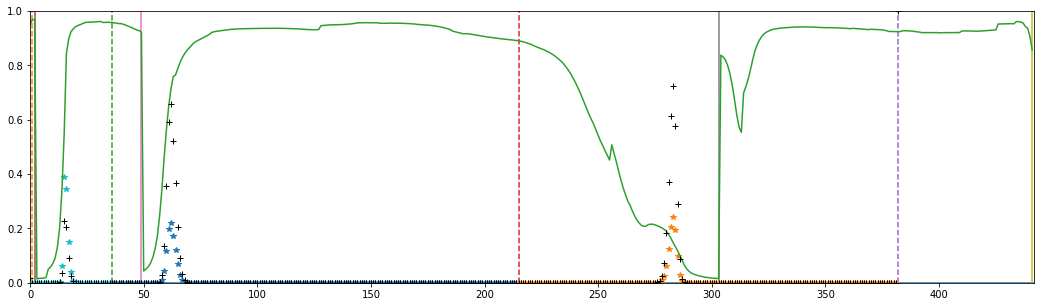

In [78]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in loaded_vidid_selected_frames[cur_vidid + ".txt"]:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
    segment = segment.cpu().numpy()
    print(f"Min prob {i} = {np.min(segment).item()}")
    xs = np.arange(loaded_vidid_selected_frames[cur_vidid + ".txt"][i], 
                   loaded_vidid_selected_frames[cur_vidid + ".txt"][i+1])
    plt.plot(xs, segment, '*')

    
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 
plt.plot(np.arange(item[1][idx].item()), plt_arr)


loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))
loss_arr = -loss_arr[0].detach().cpu().numpy()
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr/np.max(loss_arr), 'k+')

plt.ylim([0, ymax])
plt.xlim([0, item[1][idx].item()])

In [40]:
loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
print(loss_prob.shape)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))

torch.Size([1, 1895, 48])


In [43]:
loss_arr[0].shape

torch.Size([1387])

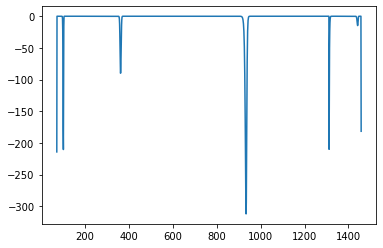

In [45]:
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr[0].detach().cpu().numpy())

In [44]:
es_loss

tensor(3.3987, device='cuda:0', dtype=torch.float64)

In [35]:
video_id_boundary_frames[cur_vidid], loaded_vidid_selected_frames[cur_vidid + ".txt"], item_1[idx]

([75, 345, 1305, 1415, 1440, 1519],
 [73, 282, 455, 1312, 1434, 1458],
 tensor(1520, device='cuda:0', dtype=torch.int32))

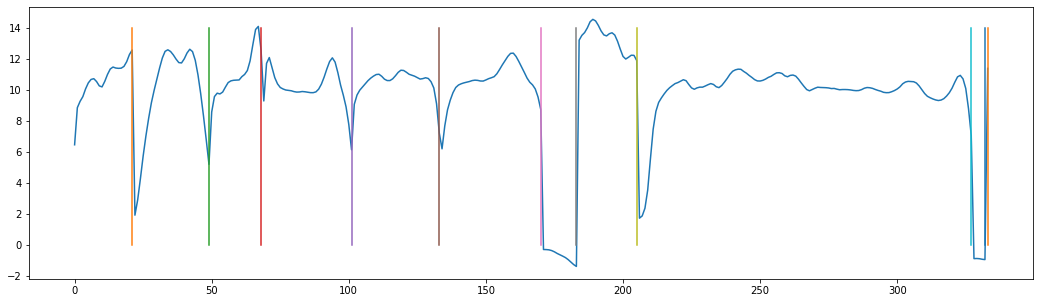

In [41]:
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 14])

torch.Size([334, 334])

In [37]:
cur_features_shortened = cur_vid_feat[:item[1][idx]]
cur_features_shortened[:, item[2][idx][:item[1][idx]]].shape
for

torch.Size([334, 334])

In [26]:
item[2][idx][video_id_boundary_frames[cur_vidid][1]-6:video_id_boundary_frames[cur_vidid][1]+9]

tensor([47, 47, 47, 47, 47, 47, 47,  4,  4,  4,  4,  4,  4,  4,  4])

In [25]:
video_id_boundary_frames[cur_vidid][0]-6,video_id_boundary_frames[cur_vidid][0]+9

6

In [27]:
cur_vid_feat[video_id_boundary_frames[cur_vidid][1]-7:video_id_boundary_frames[cur_vidid][1]+9][:,[47,4]]

tensor([[ 1.0794, 13.3350],
        [ 1.0831, 13.5102],
        [ 1.1767, 13.7662],
        [ 1.3750, 14.0177],
        [ 1.7298, 14.1727],
        [ 2.1706, 14.0367],
        [ 2.7338, 13.4563],
        [ 4.5600, 12.1745],
        [ 7.8450, 10.3246],
        [11.0151,  8.3563],
        [13.4775,  6.6546],
        [14.1836,  5.2898],
        [11.2142,  4.2791],
        [ 5.9829,  3.5694],
        [ 2.3440,  2.9389],
        [ 0.7406,  2.3515]], device='cuda:0')

In [19]:
def add_frames_and_get_classification_value(model_output, count_list, video_ids_list, labels_all, p_criterion):
    new_selected_frames = {}
#     new_selected_frames_probs_values = {}
#     new_selected_frames_labels = {}
    
    labels_arr = []
    probs_arr = []
    
    for i, video_id in enumerate(video_ids_list):
        current_boundary_frames = boundaries_dict[video_id]
        current_video_logits = model_output[i].T
        current_video_count = count_list[i]
        current_selected_frames = loaded_vidid_selected_frames[video_id]
        labels = labels_all[i]
        cur_seg_start = 0
        for seg_num, ele in enumerate(current_boundary_frames):
            cur_seg_end = ele + 1
            total_seg_len = cur_seg_end - cur_seg_start
            per_frames_far_from_boundary = int(0.3 * total_seg_len)
            new_frames_start = cur_seg_start + per_frames_far_from_boundary
            new_frames_end = cur_seg_end - per_frames_far_from_boundary
            
            frames_added = list(range(new_frames_start, new_frames_end))
            frames_added.append(current_selected_frames[seg_num])
            frames_added = list(set(frames_added))
            frames_added.sort()
            new_selected_frames[video_id] = frames_added

            
            labels_seg = torch.stack([labels[current_selected_frames[seg_num]]] * len(frames_added))
            frames_added = torch.tensor(np.array(frames_added), dtype=torch.long, device=current_video_logits.device)
            prob_seg = current_video_logits[frames_added, :]
            
            labels_arr.append(labels_seg)
            probs_arr.append(prob_seg)
            
            cur_seg_start = cur_seg_end
            
    labels_arr = torch.cat(labels_arr)
    probs_arr = torch.cat(probs_arr)
    loss = p_criterion(probs_arr, labels_arr)
    return loss